# Image Classification with TIME dataset - Team 20

In [25]:
import matplotlib.pyplot as plt

%matplotlib inline
# !pip install torchvision
import torchvision
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import os
import cv2
import numpy as np
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage.feature import hog
from skimage import exposure
from sklearn.svm import SVC
from PIL import Image


random_seed = 1
torch.manual_seed(random_seed)

DATA_DIR = "/Users/sushma/Downloads/time/kaggle"

## Read and prepare the data and data labels

In [26]:
df = pd.read_csv("/Users/sushma/Downloads/time/kaggle/clocks.csv")

printing the head value

In [27]:
df.head()

,class index,filepaths,labels,data set
0,0,train/1-00/0.jpg,1_00,train
1,0,train/1-00/1.jpg,1_00,train
2,0,train/1-00/11.jpg,1_00,train
3,0,train/1-00/12.jpg,1_00,train
4,0,train/1-00/13.jpg,1_00,train


In [28]:
keys = df.drop_duplicates("class index").copy()
keys["class index"] = keys["class index"].astype(int)
keys["labels"] = keys["labels"].str.replace("_", ":")
time_dict = dict(zip(keys["class index"], keys["labels"]))

In [29]:
df["class index"].unique().size

144

Training the files

In [30]:
train_files = df[df["data set"] == "train"]["filepaths"]
val_files = df[df["data set"] == "valid"]["filepaths"]
test_files = df[df["data set"] == "test"]["filepaths"]

print(f"Train files len: {len(train_files)}")
print(f"Val files len: {len(val_files)}")
print(f"Test files len: {len(test_files)}")

Train files len: 11520
Val files len: 1440
Test files len: 1440


Training the labels

In [31]:
train_labels = df[df["data set"] == "train"]["class index"]
val_labels = df[df["data set"] == "valid"]["class index"]
test_labels = df[df["data set"] == "test"]["class index"]

In [32]:
print(len(train_labels))

11520


In [33]:
print(train_files.head())

0     train/1-00/0.jpg
1     train/1-00/1.jpg
2    train/1-00/11.jpg
3    train/1-00/12.jpg
4    train/1-00/13.jpg
Name: filepaths, dtype: object


#### Data reading

In [34]:
#!pip install opencv-python
import cv2
from PIL import Image

In [35]:
# in our dataset 60s
def cv2_imread(path: str) -> np.ndarray:
    img = cv2.imread(path)
    try:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except:
        pass
    return img


# alternative that seems to work faster
# benchmark at https://github.com/libvips/pyvips/issues/179#issuecomment-618936358
# in our dataset 20s
def PIL_read(path: str) -> np.ndarray:
    img = Image.open(path)
    img = np.asarray(img)
    return img


# in our dataset 10s
def PILandShrink_read(path: str) -> np.ndarray:
    img = Image.open(path)
    img.draft("RGB", (1512, 1008))
    img = np.asarray(img)
    return

In [36]:
train_files = [os.path.join(DATA_DIR, path) for path in train_files]
val_files = [os.path.join(DATA_DIR, path) for path in val_files]
test_files = [os.path.join(DATA_DIR, path) for path in test_files]

In [37]:
train_images = [PIL_read(f) for f in train_files]
val_images = [PIL_read(f) for f in val_files]
test_images = [PIL_read(f) for f in test_files]


In [38]:
print(f"Length of train_images: {len(train_images)}")
print(f"Length of val_images: {len(val_images)}")
print(f"Length of test_images: {len(test_images)}")

Length of train_images: 11520
Length of val_images: 1440
Length of test_images: 1440


#### Plotting some original images with its actual time

/var/folders/8b/_s_4cdwn55l28vxhb7bb4dz00000gn/T/ipykernel_51283/2851280787.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


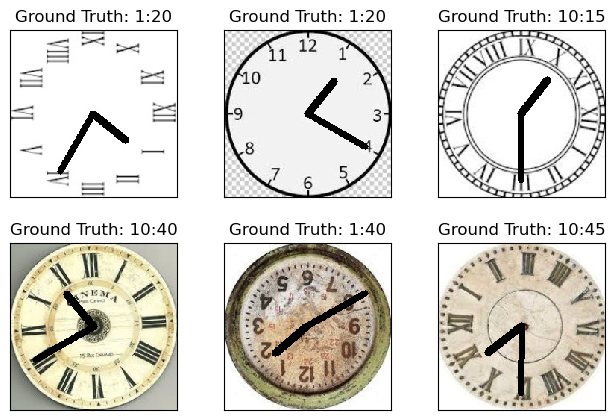

In [39]:
fig = plt.figure()
for i, random_num in enumerate([np.random.randint(1, 2000) for x in range(6)]):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    plt.imshow(train_images[random_num], cmap="gray", interpolation="none")
    plt.title(f"Ground Truth: {time_dict[train_labels[random_num]]}")
    plt.xticks([])
    plt.yticks([])

#### Convert to train  and test images to array

In [46]:
X_train = np.array(train_images).astype("float32")
X_test = np.array(test_images).astype("float32")

In [47]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

Normalize (dividing by 255)

In [49]:
(X_train, X_test) = X_train / 255, X_test / 255

In [50]:
print(f"X_train shape:{X_train.shape}")
print(f"y_train shape:{y_train.shape}")
print(f"X_test shape:{X_test.shape}")
print(f"y_test shape:{y_test.shape}")

X_train shape:(11520, 224, 224, 3)
y_train shape:(11520,)
X_test shape:(1440, 224, 224, 3)
y_test shape:(1440,)


# 1. CNN Model

In [64]:
from torch.utils.data import Dataset, DataLoader

In [65]:
# Setting the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device
"""https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228"""
torch.set_num_threads(1)

In [66]:
batch_size = 32

### Loading the data for training

In [67]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X_train)
        self.X = self.X.permute(0, 3, 1, 2)
        self.y = torch.from_numpy(y_train)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

In [68]:
training = Data(X_train, y_train)
testing = Data(X_test, y_test)
train_loader = DataLoader(
    dataset=training, batch_size=batch_size, shuffle=True, num_workers=0
)
test_loader = DataLoader(
    dataset=testing, batch_size=batch_size, shuffle=True, num_workers=0
)

In [69]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

/var/folders/8b/_s_4cdwn55l28vxhb7bb4dz00000gn/T/ipykernel_51283/4211768996.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


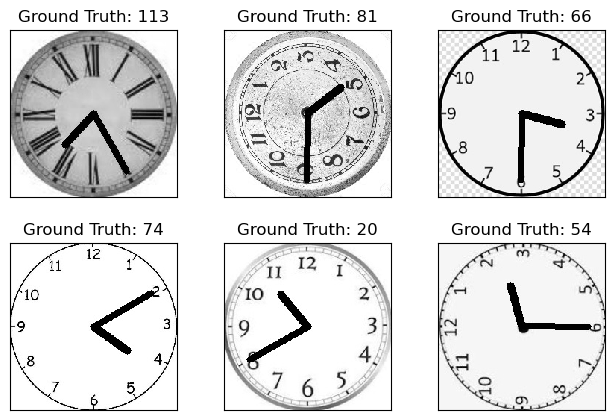

In [70]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()

    plt.imshow(example_data[i][0], cmap="gray", interpolation="none")
    plt.title(f"Ground Truth: {example_targets[i]}")
    plt.xticks([])
    plt.yticks([])

In [71]:
for batch, (X, y) in enumerate(train_loader):
    print(f"Batch: {batch+1}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    break

Batch: 1
X shape: torch.Size([32, 3, 224, 224])
y shape: torch.Size([32])


In [72]:
class NeuralNetwork(nn.Module):
    def __init__(self) -> None:
        super(NeuralNetwork, self).__init__()
        # Default padding=0 and stride =1
        self.conv1 = nn.Conv2d(3, 10, kernel_size=10, stride=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=8, stride=2)
        self.conv2_dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(2880, 200)
        self.fc2 = nn.Linear(200, 144)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))

        x = F.relu(F.max_pool2d(self.conv2_dropout(self.conv2(x)), 2))
        x = x.view(-1, 2880)

        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)

        x = self.fc2(x)
        softmax = F.log_softmax(x, 1)
        return softmax

In [73]:
# Hyperparameters
epochs = 30
learning_rate = 0.01
momentum = 0.5
log_interval = 100

network = NeuralNetwork()
network = network.to(device)
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

In [74]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i * len(train_loader.dataset) for i in range(epochs + 1)]

In [75]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                f"Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} ({100.0 * batch_idx / len(train_loader):.2f}%)]\tLoss: {loss.item():.5f}",
            )
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx * 32) + ((epoch - 1) * len(train_loader.dataset))
            )


In [76]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data = data.to(device)
            target = target.to(device)
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print(
        f"\nTest set: Avg. loss: {test_loss:.5f}, Accuracy: {correct}/{len(test_loader.dataset)} ({100.0 * correct / len(test_loader.dataset):.2f}%)\n"
    )

In [67]:
test()
for epoch in range(1, epochs + 1):
    train(epoch)
    test()

/Users/samhithdara/anaconda3/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 4.97085, Accuracy: 79/11520 (0.69%)

Train Epoch: 1 [0/11520 (0.00%)]	Loss: 4.96665
Train Epoch: 1 [3200/11520 (27.78%)]	Loss: 4.96409
Train Epoch: 1 [6400/11520 (55.56%)]	Loss: 4.96771
Train Epoch: 1 [9600/11520 (83.33%)]	Loss: 4.97386

Test set: Avg. loss: 4.96907, Accuracy: 91/11520 (0.79%)

Train Epoch: 2 [0/11520 (0.00%)]	Loss: 4.97443
Train Epoch: 2 [3200/11520 (27.78%)]	Loss: 4.97768
Train Epoch: 2 [6400/11520 (55.56%)]	Loss: 4.95547
Train Epoch: 2 [9600/11520 (83.33%)]	Loss: 4.97139

Test set: Avg. loss: 4.96416, Accuracy: 137/11520 (1.19%)

Train Epoch: 3 [0/11520 (0.00%)]	Loss: 4.98090
Train Epoch: 3 [3200/11520 (27.78%)]	Loss: 4.96051
Train Epoch: 3 [6400/11520 (55.56%)]	Loss: 4.95008
Train Epoch: 3 [9600/11520 (83.33%)]	Loss: 4.94730

Test set: Avg. loss: 4.91991, Accuracy: 361/11520 (3.13%)

Train Epoch: 4 [0/11520 (0.00%)]	Loss: 4.93687
Train Epoch: 4 [3200/11520 (27.78%)]	Loss: 4.87339
Train Epoch: 4 [6400/11520 (55.56%)]	Loss: 4.78324
Train Epoch: 

In [77]:
import pickle

# Load the classifier from the saved file
with open('cnn.pkl', 'rb') as f:
    network = pickle.load(f)

from sklearn.metrics import precision_score, recall_score

In [79]:
with torch.no_grad():
    output = network(example_data.to(device))

### Plotting some images with its predicted time

/var/folders/8b/_s_4cdwn55l28vxhb7bb4dz00000gn/T/ipykernel_51283/614228488.py:4: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


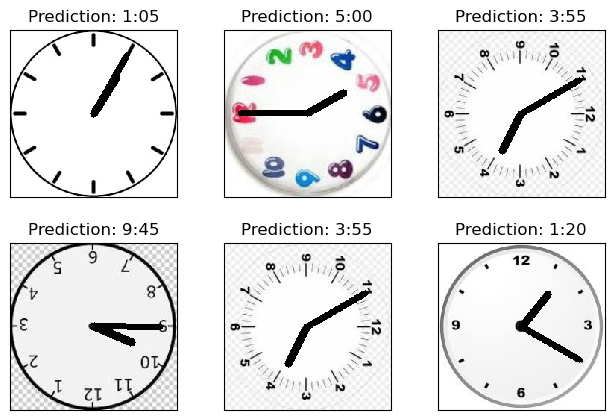

In [80]:
fig = plt.figure()
for i, random_num in enumerate([np.random.randint(1, 32) for x in range(6)]):
    plt.subplot(2, 3, i + 1)
    plt.tight_layout()
    # Permutation needed to add color again
    plt.imshow(
        example_data[random_num].permute(1, 2, 0), cmap="gray", interpolation="none"
    )
    plt.title(
        f"Prediction: {time_dict[output.data.max(1, keepdim=True)[1][random_num].item()]}"
    )
    plt.xticks([])
    plt.yticks([])

### Evaluation metrics: Calculating Accuracy, Precision, Recall and confusion matrix

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        80
           3       1.00      1.00      1.00        80
           4       1.00      1.00      1.00        80
           5       1.00      1.00      1.00        80
           6       1.00      1.00      1.00        80
           7       1.00      1.00      1.00        80
           8       1.00      1.00      1.00        80
           9       1.00      1.00      1.00        80
          10       1.00      1.00      1.00        80
          11       1.00      1.00      1.00        80
          12       1.00      1.00      1.00        80
          13       1.00      1.00      1.00        80
          14       1.00      1.00      1.00        80
          15       1.00      1.00      1.00        80
          16       1.00      1.00      1.00        80
    

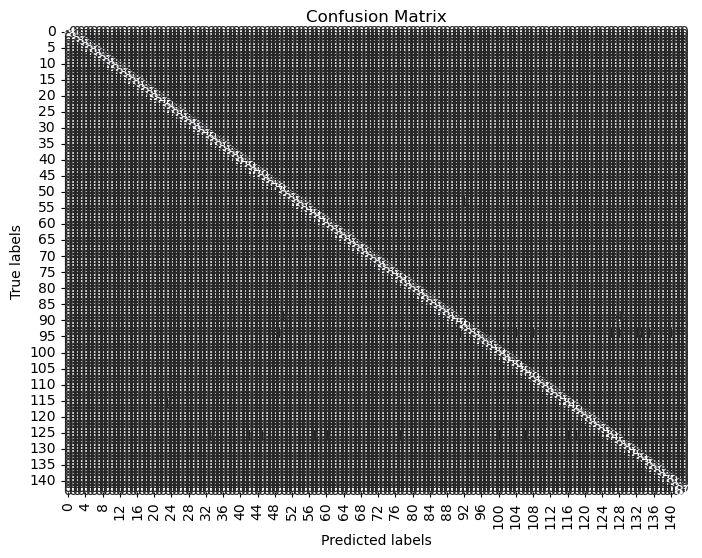

CNN Accuracy: 99.77%
CNN Precision: 0.9977
CNN Recall: 0.9977


In [87]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for data, target in data_loader:
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            predictions.extend(pred.cpu().numpy())
            true_labels.extend(target.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='weighted')
    recall = recall_score(true_labels, predictions, average='weighted')
    print("Classification Report:")
    print(classification_report(true_labels, predictions))

    cm = confusion_matrix(true_labels, predictions)
    
    # Plotting confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.show()



    return accuracy, precision, recall

test_accuracy, test_precision, test_recall = evaluate_model(network, test_loader)

print(f"CNN Accuracy: {test_accuracy * 100:.2f}%")
print(f"CNN Precision: {test_precision:.4f}")
print(f"CNN Recall: {test_recall:.4f}")

The Accuracy, Precision, Recall and confusion matrix for the CNN model implemented is presented. We can clearly see that the CNN Accuracy percentage is 99.77%

# 2. SVM Model

The below is the SVM classification model implementation. Feature extraction transforms raw image data into a format suitable for machine learning. Here, we use HOG which is a popular technique for capturing shape and edge information. We are extracting HOG features for training and test images

In [40]:
def extract_hog_features(images):
    features = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=False)
        features.append(hog_features)
    return np.array(features)

X_train_features = extract_hog_features(train_images)
X_test_features = extract_hog_features(test_images)


In [30]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

training = Data(X_train_features, y_train)
testing = Data(X_test_features, y_test)
train_loader = DataLoader(dataset=training, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=testing, batch_size=32, shuffle=True, num_workers=0)


In [31]:
# I have used pickle inorder to save time during execution. Since running each model is taking more than 2 hours, I have used this module to create
# pickle files of the models. Using this approach, instead of training the model again and again, I'm using the trained model from the pickle file.
# The same approach has been followed for all the 4 models implemented
# I have added all the pickle files in the same project directory for your reference

# import pickle

# # Load the classifier from the saved file
# with open('svm_classifier.pkl', 'rb') as f:
#     svm_classifier = pickle.load(f)




### Calculation SVM Model's Accuracy, Precision, Recall, F1 Score (Evaluation Metrics)

In [32]:

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

from sklearn.metrics import classification_report


y_pred = svm_classifier.predict(X_test_features)

accuracy_SVM = svm_classifier.score(X_test_features, y_test)
print(f"SVM Model Test Accuracy: {accuracy_SVM * 100:.2f}%")

precision_SVM = precision_score(y_test, y_pred, average='weighted')
recall_SVM = recall_score(y_test, y_pred, average='weighted')


print(f'SVM Model Precision: {precision_SVM:.2f}')
print(f'SVM Model Recall: {recall_SVM:.2f}')

f1_score_SVM = f1_score(y_test, y_pred, average='weighted')
print(f"SVM Model F1 Score: {f1_score_SVM:.2f}")

report = classification_report(y_test, y_pred, target_names=time_dict.values())

print("Classification Report (SVM Model):\n", report)

SVM Model Test Accuracy: 57.57%
SVM Model Precision: 0.60
SVM Model Recall: 0.58
SVM Model F1 Score: 0.57
Classification Report (SVM Model):
               precision    recall  f1-score   support

        1:00       0.36      0.40      0.38        10
        1:05       0.50      0.70      0.58        10
        1:10       1.00      0.60      0.75        10
        1:15       0.53      0.80      0.64        10
        1:20       0.45      0.50      0.48        10
        1:25       0.38      0.60      0.46        10
        1:30       0.50      0.70      0.58        10
        1:35       0.56      0.50      0.53        10
        1:40       0.36      0.40      0.38        10
        1:45       0.50      0.50      0.50        10
        1:50       0.67      0.80      0.73        10
        1:55       0.38      0.30      0.33        10
       10:00       0.40      0.60      0.48        10
       10:05       0.55      0.60      0.57        10
       10:10       0.47      0.70      0.56    

The Accuracy, Precision, Recall for the SVM model implemented is presented. We can see that the SVM Model's Accuracy percentage is 57.57% which is lesser than the CNN model as of now.

# 3. Decision Tree

The below is the Decision Tree classification model implementation. Feature extraction transforms raw image data into a format suitable for machine learning. Here, we use HOG which is a popular technique for capturing shape and edge information. We are extracting HOG features for training and test images

In [41]:
from sklearn.tree import DecisionTreeClassifier
def extract_hog_features(images):
    features = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=False)
        features.append(hog_features)
    return np.array(features)

X_train_features = extract_hog_features(train_images)
X_test_features = extract_hog_features(test_images)

#### Initializing and training the decision tree classifier

In [52]:
decision_tree_classifier = DecisionTreeClassifier(random_state=random_seed)

decision_tree_classifier.fit(X_train_features, y_train)

DecisionTreeClassifier(random_state=1)

In [53]:
# import pickle

# with open('decision_tree_classifier.pkl', 'wb') as f:
#     pickle.dump(decision_tree_classifier, f)

### Calculation Decision Tree's Accuracy, Precision, Recall, F1 Score (Evaluation Metrics)

In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import classification_report


y_pred = decision_tree_classifier.predict(X_test_features)

accuracy_decision_tree = accuracy_score(y_test, y_pred)
print(f"Decision Tree Test Accuracy: {accuracy_decision_tree * 100:.2f}%")

precision_decision_tree = precision_score(y_test, y_pred, average='weighted')
print(f"Decision Tree Precision: {precision_decision_tree:.2f}")

recall_decision_tree = recall_score(y_test, y_pred, average='weighted')
print(f"Decision Tree Recall: {recall_decision_tree:.2f}")

f1_decision_tree = f1_score(y_test, y_pred, average='weighted')
print(f"Decision Tree F1 Score: {f1_decision_tree:.2f}")

report = classification_report(y_test, y_pred, target_names=time_dict.values())

print("Classification Report Decision Tree:\n", report)

Decision Tree Test Accuracy: 72.22%
Decision Tree Precision: 0.74
Decision Tree Recall: 0.72
Decision Tree F1 Score: 0.72
Classification Report Decision Tree:
               precision    recall  f1-score   support

        1:00       0.64      0.70      0.67        10
        1:05       0.43      0.30      0.35        10
        1:10       1.00      0.80      0.89        10
        1:15       0.80      0.80      0.80        10
        1:20       0.62      0.50      0.56        10
        1:25       1.00      0.80      0.89        10
        1:30       0.64      0.70      0.67        10
        1:35       0.88      0.70      0.78        10
        1:40       0.73      0.80      0.76        10
        1:45       0.83      1.00      0.91        10
        1:50       0.71      0.50      0.59        10
        1:55       0.70      0.70      0.70        10
       10:00       0.58      0.70      0.64        10
       10:05       0.45      0.50      0.48        10
       10:10       1.00      

The Accuracy, Precision, Recall for the CNN model implemented is presented. We can clearly see that the Accuracy is 72.22%. The accuracy is lesser than the CNN model but it is greater than the SVM Model.

# 4. Random forest

The below is the Random forest classification model implementation. Feature extraction transforms raw image data into a format suitable for machine learning. Here, we use HOG which is a popular technique for capturing shape and edge information. We are extracting HOG features for training and test images

In [26]:
def extract_hog_features(images):
    features = []
    for image in images:
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        hog_features = hog(gray_image, orientations=9, pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2), visualize=False)
        features.append(hog_features)
    return np.array(features)

X_train_features = extract_hog_features(train_images)
X_test_features = extract_hog_features(test_images)


In [27]:
class Data(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)
        self.len = self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]

    def __len__(self):
        return self.len

training = Data(X_train_features, y_train)
testing = Data(X_test_features, y_test)
train_loader = DataLoader(dataset=training, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=testing, batch_size=32, shuffle=True, num_workers=0)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=random_seed)

rf_classifier.fit(X_train_features, y_train)

accuracy = rf_classifier.score(X_test_features, y_test)
print(f"Test Accuracy (Random Forest): {accuracy * 100:.2f}%")


In [58]:
# import pickle

# # Assuming you have a trained SVM classifier named 'svm_classifier'
# # Save the classifier to a file
# with open('random_forest.pkl', 'wb') as f:
#     pickle.dump(rf_classifier, f)

# import pickle

# # Load the classifier from the saved file
# with open('random_forest.pkl', 'rb') as f:
#     rf_classifier = pickle.load(f)

# from sklearn.metrics import precision_score, recall_score

### Calculation Random forest Accuracy, Precision, Recall, F1 Score (Evaluation Metrics)

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report


y_pred = rf_classifier.predict(X_test_features)

accuracy_random_forest = accuracy_score(y_test, y_pred)
print(f"Random Forest Test Accuracy: {accuracy_random_forest * 100:.2f}%")

precision_random_forest = precision_score(y_test, y_pred, average='weighted')
print(f"Random Forest Precision: {precision_random_forest:.2f}")

recall_random_forest = recall_score(y_test, y_pred, average='weighted')
print(f"Random Forest Recall: {recall_random_forest:.2f}")

f1_random_forest = f1_score(y_test, y_pred, average='weighted')
print(f"Random Forest F1 Score: {f1_random_forest:.2f}")

report = classification_report(y_test, y_pred, target_names=time_dict.values())

print("Classification Report Random Forest:\n", report)

Random Forest Test Accuracy: 89.65%
Random Forest Precision: 0.91
Random Forest Recall: 0.90
Random Forest F1 Score: 0.90
Classification Report Random Forest:
               precision    recall  f1-score   support

        1:00       0.80      0.80      0.80        10
        1:05       0.82      0.90      0.86        10
        1:10       1.00      1.00      1.00        10
        1:15       0.82      0.90      0.86        10
        1:20       0.89      0.80      0.84        10
        1:25       0.77      1.00      0.87        10
        1:30       1.00      0.90      0.95        10
        1:35       0.91      1.00      0.95        10
        1:40       0.82      0.90      0.86        10
        1:45       1.00      0.90      0.95        10
        1:50       0.83      1.00      0.91        10
        1:55       1.00      0.80      0.89        10
       10:00       0.82      0.90      0.86        10
       10:05       0.73      0.80      0.76        10
       10:10       1.00      

The Accuracy, Precision, Recall for the Random forest model implemented is presented. We can see that the Random forest Accuracy percentage is 89.65% which is greater than the Decision Tree and SVM but it is less than the CNN Model accuracy.

## The below snippet helps to evaluate the best model

In [90]:
cnn_accuracy = test_accuracy
cnn_precision = test_precision
cnn_recall = test_recall


models = {
    "CNN": {"accuracy": cnn_accuracy, "precision": cnn_precision, "recall": cnn_recall},
    "SVM": {"accuracy": accuracy_SVM, "precision": precision_SVM, "recall": recall_SVM},
    "Decision Tree": {"accuracy": accuracy_decision_tree, "precision": precision_decision_tree, "recall": recall_decision_tree},
    "Random Forest": {"accuracy": accuracy_random_forest, "precision": precision_random_forest, "recall": recall_random_forest}
}

def evaluate_best_model(metric):
    best_model = max(models, key=lambda x: models[x][metric])
    best_value = models[best_model][metric]
    print(f"The best model based on {metric} is {best_model} with a value of {best_value:.4f}")

# Evaluate the best model based on accuracy
evaluate_best_model("accuracy")

# Evaluate the best model based on precision
evaluate_best_model("precision")

# Evaluate the best model based on recall
evaluate_best_model("recall")

The best model based on accuracy is CNN with a value of 0.9977
The best model based on precision is CNN with a value of 0.9977
The best model based on recall is CNN with a value of 0.9977


From the above metrics, it is clear that the CNN Model has the highest evaluation metrics i.e., the accuracy, precision, recall being 0.9977. Hyperparameter tuning hasn't been performed as standard parameters gave the highest accuracy. Thus, we can conclude from the above results that the CNN model works as the best image classification model to predict the time.